# ADVI Inference of a near genome-scale kinetic model from multiomics data

This notebook contains the analysis of the ADVI results on the data from Hackett et al, 2016 [1], analyzed with the yeast model from Jol et al., 2012 [2]. The actual model construction and inference are perfomed in a separate python file, `run_hackett_inference.py`.

1. Hackett, S.R., Zanotelli, V.R.T., Xu, W., Goya, J., Park, J.O., Perlman, D.H., Gibney, P.A., Botstein, D., Storey, J.D., and Rabinowitz, J.D. (2016). Systems-level analysis of mechanisms regulating yeast metabolic flux. Science 354, aaf2786–aaf2786.
2. Jol, S.J., Kümmel, A., Terzer, M., Stelling, J., and Heinemann, M. (2012). System-level insights into yeast metabolism by thermodynamic analysis of elementary flux modes. PLoS Computational Biology 8, e1002415.

In [1]:
import sys
print(sys.version)

3.11.0 | packaged by conda-forge | (main, Jan 14 2023, 12:26:40) [Clang 14.0.6 ]


In [2]:
from run_hackett_inference import *

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks', color_codes=True)

from tqdm import tqdm

%matplotlib inline

In [4]:
r_labels = [r.id for r in model.reactions]

load the previously stored approximation

In [9]:
import gzip
import cloudpickle

with gzip.open('/Users/mcna892/Downloads/hackett_advi.pgz', 'rb') as f:
    hist = cloudpickle.load(f)

plot of ELBO convergence vs iteration

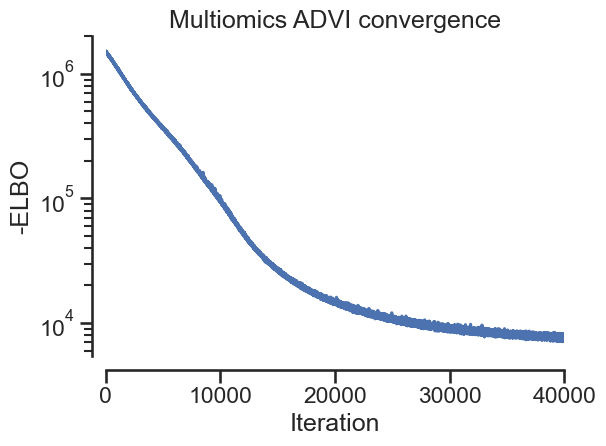

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.semilogy(hist['hist'].hist, '-', ms=1, rasterized=True)
ax.set_xlim([0, 40000])

sns.despine(offset=10)
ax.set_xlabel('Iteration')
ax.set_ylabel('-ELBO')
ax.set_title('Multiomics ADVI convergence')

plt.tight_layout()

# plt.savefig('hackett_advi.svg')

Sample the approximation to generate a 'trace' and posterior predictive distribution

In [22]:
with pymc_model:
    
    trace = hist['hist'].sample(500)
    ppc = pm.sample_posterior_predictive(trace)

Sampling: [chi_obs, vn_obs]


In [76]:
trace.posterior['vn_ss'][:, :, :,197]

<xarray.DataArray 'vn_ss' (chain: 1, draw: 500, vn_ss_dim_0: 24)>
array([[[0.27628323, 0.28559746, 0.38784255, ..., 1.55559623,
         1.9308956 , 2.58060262],
        [0.24910984, 0.33344431, 0.36964782, ..., 1.46233893,
         1.81832594, 2.64448917],
        [0.24423985, 0.30930245, 0.32907231, ..., 1.54750913,
         1.99703335, 2.56637851],
        ...,
        [0.26453446, 0.34664261, 0.37292615, ..., 1.44517888,
         1.8329905 , 2.66139651],
        [0.24286974, 0.33582148, 0.39392943, ..., 1.39685585,
         1.9132778 , 2.52041321],
        [0.2904455 , 0.38024789, 0.41889102, ..., 1.46924619,
         1.89046452, 2.5267685 ]]])
Coordinates:
  * chain        (chain) int64 0
  * draw         (draw) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * vn_ss_dim_0  (vn_ss_dim_0) int64 0 1 2 3 4 5 6 7 ... 16 17 18 19 20 21 22 23
    vn_ss_dim_1  int64 197

In [74]:
def plot_hpd(ax, real, ppc, error=True, ms=3, alpha=0.5, color='b'):
    if error:
        ax.plot(np.vstack([real.values.flatten(), real.values.flatten()]),
                pm.hdi(ppc).to_array().to_numpy().reshape(-1, 2).T, color=color, lw=1, alpha=0.05, zorder=0)
    ax.plot(real, ppc.median(dim=['chain','draw']), '.', ms=ms, color=color, alpha=alpha, zorder=0)

Metabolites are given in relative concentrations, which actually works perfectly for this analysis.

Specifically, the concentrations are given by $$x = A 2^a,$$ where $A$ is `Conversion_to_Absolute` and $a$ are the columns of `metabolites`.

For a given reference state $x^* = A 2^b,$ $$\chi = \log(\frac{x}{x^*}) = \log\left(\frac{A 2^a}{A 2^b}\right) = (a - b) \log 2$$

Therefore we can calculate values of $\chi$ even when absolute metabolite concentrations aren't known.
Enzymes are also reported as $\log_2$ transformed variables.
For $\hat{e}$, we need $$\frac{e}{e^*} = \frac{A 2^{y}}{A 2 ^{y^*}} = 2^{y - y^*}$$

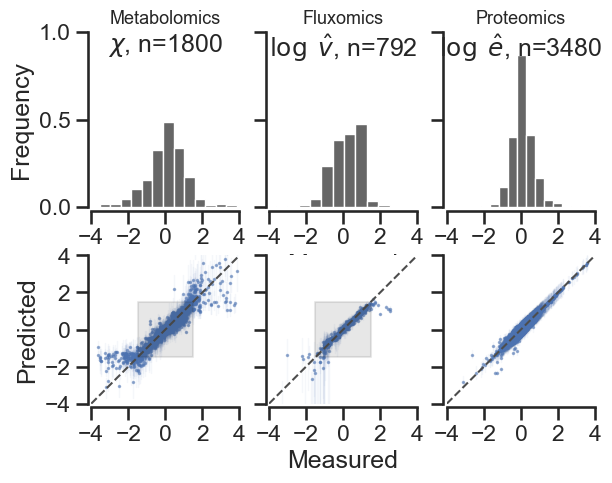

In [79]:
plt.rcParams["axes.axisbelow"] = False

fig, ax_matrix = plt.subplots(ncols=3, nrows=2, figsize=(6.5, 5),
                              sharex='row', sharey='row')

for ax in ax_matrix[1,:].flatten():
    ax.set_aspect('equal')

_ = ax_matrix[0,0].hist(xn.values.flatten(), bins=15, lw=1,
                        edgecolor='w', density=True, facecolor='.4')
_ = ax_matrix[0,1].hist(np.log(np.clip(vn.values.flatten(), 1E-8, 1E8)), bins=15, lw=1,
                        edgecolor='w', density=True, facecolor='.4')
_ = ax_matrix[0,2].hist(np.log(en.values.flatten()), bins=15, lw=1, edgecolor='w',
                        density=True, facecolor='.4')

plot_hpd(ax_matrix[1,0], xn,
         trace.posterior['chi_ss'][:, :, :, x_inds])
plot_hpd(ax_matrix[1,1], np.log(vn),
         np.log(np.clip(trace.posterior['vn_ss'][:, :, :, v_inds], 1E-8, 1E8)))
plot_hpd(ax_matrix[1,2], np.log(en),
         trace.posterior['log_en_t'][:, :, :, e_inds])

for ax in ax_matrix[1,:]:
    ax.set_rasterization_zorder(1)

ax_matrix[1,0].set_xlim([-4, 4])
ax_matrix[1,1].set_xlim([-4, 4])
ax_matrix[1,2].set_xlim([-4, 4])
ax_matrix[1,0].set_ylim([-4, 4])
ax_matrix[1,1].set_ylim([-4, 4])
ax_matrix[1,2].set_ylim([-4, 4])

for ax in ax_matrix[0,:]:
    ax.set_xlim([-4, 4])
    ax.set_xticks([-4, -2, 0, 2, 4])

for ax in ax_matrix[1,:]:
    ax.plot([-4, 4], [-4, 4], '--', color='.3', zorder=4, lw=1.5)
    ax.set_xlim([-4, 4])
    ax.set_ylim([-4, 4])

    ax.set_xticks([-4, -2, 0, 2, 4])
    ax.set_yticks([-4, -2, 0, 2, 4])
    
    
ax_matrix[1,0].fill_between([-1.5, 1.5], [1.5, 1.5], [-1.5, -1.5],
                            zorder=4, color='k', alpha=.1)
ax_matrix[1,1].fill_between([-1.5, 1.5], [1.5, 1.5], [-1.5, -1.5],
                            zorder=4, color='k', alpha=.1)

ax_matrix[0, 0].set_ylim([0, 1.])

ax_matrix[0,0].set_title('Metabolomics', fontsize=13)
ax_matrix[0,1].set_title('Fluxomics', fontsize=13)
ax_matrix[0,2].set_title('Proteomics', fontsize=13)


ax_matrix[0,0].text(0.5, 1., '$\chi$, n={}'.format(xn.shape[0] * xn.shape[1]),
                    ha='center', va='top', transform=ax_matrix[0,0].transAxes)
ax_matrix[0,1].text(0.5, 1., '$\log\; \hat{v}$, n='+ str(vn.shape[0] * vn.shape[1]),
                    ha='center', va='top', transform=ax_matrix[0,1].transAxes)
ax_matrix[0,2].text(0.5, 1., '$\log\; \hat{e}$, n=' + str(en.shape[0] * en.shape[1]),
                    ha='center', va='top', transform=ax_matrix[0,2].transAxes)

ax_matrix[0,1].set_xlabel('Measured')
ax_matrix[-1,1].set_xlabel('Measured')
ax_matrix[1,0].set_ylabel('Predicted')
ax_matrix[0,0].set_ylabel('Frequency')

sns.despine(offset=2.5, trim=True)
# plt.tight_layout()

# plt.savefig('hackett_posterior_and_dists.svg', dpi=300)

In [80]:
from sklearn.metrics import mean_absolute_error

ModuleNotFoundError: No module named 'sklearn'

In [91]:
chi_median = trace.posterior["chi_ss"][:, :, :, x_inds].median(dim=["chain","draw"])

np.nanmedian((xn[(xn <= 1.5) & (xn >= -1.5)]
              - chi_median.to_numpy()).abs().values)

0.1348572401317068

In [92]:
vn_median = trace.posterior["vn_ss"][:, :, :, v_inds].median(dim=["chain","draw"])

np.nanmedian((np.log(vn)[(np.log(vn) <= 1.5) & (np.log(vn) >= -1.5)]
             - np.median(np.log(np.clip(vn_median.to_numpy(),
                                        1E-8, 1E8)), 0)).abs().values)

0.39467319387791144

In [93]:
en_median = trace.posterior["log_en_t"][:, :, :, e_inds].median(dim=["chain","draw"])

np.nanmedian((np.log(en)[(np.log(en) <= 1.5) & (np.log(en) >= -1.5)]
             - en_median.to_numpy()).abs().values)

0.02179910091990786

In [104]:
e_unmeasured_hpd = pm.hdi(trace.posterior['log_e_unmeasured'])
e_consistent = np.sign(e_unmeasured_hpd.to_array()[:, :, 0]) == np.sign(e_unmeasured_hpd.to_array()[:, :, 1])

In [17]:
e_consistent.any(0)  # 25/50 enzymes are nonzero at least once.

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [105]:
capacity_hpd = pm.hdi(trace.posterior['ex_capacity_entries'])

In [160]:
capacity_consistent = np.sign(capacity_hpd.to_array()[:, :, 0][0]) == np.sign(capacity_hpd.to_array()[:, :, 1][0])

In [161]:
capacity_consistent.sum()

<xarray.DataArray ()>
array(198)
Coordinates:
    variable  <U19 'ex_capacity_entries'

In [162]:
capacity_consistent.sum() / len(capacity_consistent)

<xarray.DataArray ()>
array(0.00728799)
Coordinates:
    variable  <U19 'ex_capacity_entries'

In [283]:
e_laplace_inds

array([  5,  16,  25,  47,  66,  72,  75,  77,  80,  82,  96, 111, 112,
       115, 122, 123, 124, 125, 131, 152, 205, 206, 207, 208, 209, 210,
       211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223,
       224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234])

Here I compare the flux control coefficients as calculated via the least-norm linear solve to those calculated via a traditional link matrix method.

In [164]:
ll_link = emll.LinLogLinkMatrix(ll.N, ll.Ex, ll.Ey, ll.v_star)

In [172]:
fccs = np.array([ll.flux_control_coefficient(Ex=ex) for ex in tqdm(trace.posterior['Ex'][0].to_numpy())])
fccs_link = np.array([ll_link.flux_control_coefficient(Ex=ex) for ex in tqdm(trace.posterior['Ex'][0].to_numpy())])





  0%|                                                                                         | 0/500 [00:00<?, ?it/s]



  0%|▏                                                                                | 1/500 [00:01<12:02,  1.45s/it]



  0%|▎                                                                                | 2/500 [00:03<13:28,  1.62s/it]



  1%|▍                                                                                | 3/500 [00:04<13:04,  1.58s/it]



  1%|▋                                                                                | 4/500 [00:06<12:53,  1.56s/it]



  1%|▊                                                                                | 5/500 [00:07<13:05,  1.59s/it]



  1%|▉                                                                                | 6/500 [00:09<13:05,  1.59s/it]



  1%|█▏                                                                               | 7/500 [00:11<13:06,  1.59s/it]



  2%|█▎             

In [173]:
fccs.shape

(500, 240, 240)

In [174]:
r_med = np.median(fccs, 0).flatten()
l_med = np.median(fccs_link, 0).flatten()

r_err = [r_med - np.percentile(fccs, 25, axis=0).flatten(),
         np.percentile(fccs, 75, axis=0).flatten() - r_med]
l_err = [l_med - np.percentile(fccs_link, 25, axis=0).flatten(),
         np.percentile(fccs_link, 75, axis=0).flatten() - l_med]

  0%|                                                                                           | 0/1 [28:13<?, ?it/s]


Text(1, -1, '$\\rho = 0.90$')

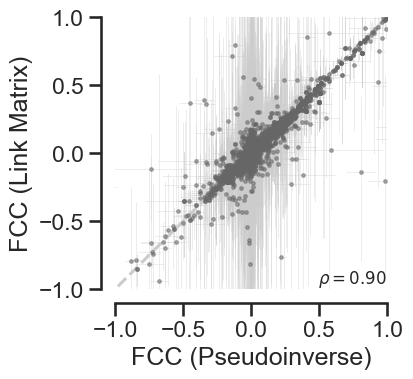

In [175]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111, aspect='equal', adjustable='box')

ax.set_aspect('equal')
ax.errorbar(r_med, l_med, ms=5, lw=0, xerr=r_err, yerr=l_err,
            marker='.', color='.4', zorder=3, alpha=0.5)
ax.errorbar(r_med, l_med, ms=5, lw=0, xerr=r_err, yerr=l_err,
            elinewidth=.5, color='.8', alpha=0.5, zorder=2)

ax.plot([-5, 5], [-5, 5], '--', color='.8', zorder=0)

ax.set_xlabel('FCC (Pseudoinverse)')
ax.set_ylabel('FCC (Link Matrix)')

ax.set_rasterization_zorder(4)

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])


plt.tight_layout()
sns.despine(trim=True, offset=10)
ax.text(1, -1, '$\\rho = {:.2f}$'.format(
    pd.Series(r_med).corr(pd.Series(l_med))), ha='right', va='bottom', fontsize=12)

# plt.savefig('fcc_comparison.svg', dpi=300)

In [176]:
fcc_med = np.median(fccs, 0)
fcc_med = pd.DataFrame(fcc_med, columns=r_labels, index=r_labels)

In [177]:
def corrwith(left, right, df=True):
    # demeaned data
    left_tiled = np.repeat(left.values[:, np.newaxis, :], right.shape[0], 1)
    right_tiled = np.repeat(right.values[np.newaxis, :, :], left.shape[0], 0)

    ldem = left_tiled - left_tiled.mean(-1)[:, :, np.newaxis]
    rdem = right_tiled - right_tiled.mean(-1)[:, :, np.newaxis]

    num = (ldem * rdem).sum(-1)

    dom = (left.shape[1] - 1) * left_tiled.std(-1) * right_tiled.std(-1)
    correl = num / dom
    
    if not df:
        return correl
    else: 
        return pd.DataFrame(correl, index=left.index, columns=right.index)

corr_df = corrwith(e, v).T

In [178]:
def random_corr_iterator():
    return corrwith(e.loc[:, np.random.permutation(e.columns)],
                    v.loc[:, np.random.permutation(e.columns)], df=False)

In [179]:
permuted_corr_mat = np.array([random_corr_iterator() for _ in tqdm(range(2000))])

100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 912.94it/s]


In [180]:
import scipy
from scipy import cluster

z_scores = (corr_df - permuted_corr_mat.mean(0).T) / permuted_corr_mat.std(0).T
p_vals = 2 * z_scores.abs().apply(scipy.stats.norm.sf)

def sort_df(df):
    sort_x = cluster.hierarchy.leaves_list(cluster.hierarchy.linkage(df, "complete"))
    sort_y = cluster.hierarchy.leaves_list(cluster.hierarchy.linkage(df.T, "complete"))
    
    return df.iloc[sort_x, sort_y]

In [299]:
fccs.shape

(500, 240, 240)

In [301]:
# Initialize an empty array to store HDI results
fccs_hdi = np.zeros((240, 240, 2))

# Calculate HDI for each slice along the first dimension
for i in range(fccs.shape[1]):
    for j in range(fccs.shape[2]):
        hdi = pm.hdi(fccs[:, i, j])  # Compute HDI for each element (across the 500 dimension)
        fccs_hdi[i, j] = hdi  # Store HDI results


In [302]:
fcc_consistent = np.sign(fccs_hdi[:, :, 0]) == np.sign(fccs_hdi[:, :, 1])
fcc_consistent_df = pd.DataFrame(fcc_consistent, columns=r_labels, index=r_labels)

In [303]:
sorted_corr_df = sort_df(corr_df)

fcc_med_measured = fcc_med.reindex(
    columns=sorted_corr_df.columns, index=sorted_corr_df.index)
fcc_consistent_measured = fcc_consistent_df.reindex(
    columns=sorted_corr_df.columns, index=sorted_corr_df.index)

In [298]:
fccs_hpd = pm.hdi(fccs)
fcc_consistent = np.sign(fccs_hpd[:, :, 0]) == np.sign(fccs_hpd[:, :, 1])
fcc_consistent_df = pd.DataFrame(fcc_consistent, columns=r_labels, index=r_labels)

sorted_corr_df = sort_df(corr_df)

fcc_med_measured = fcc_med.reindex(
    columns=sorted_corr_df.columns, index=sorted_corr_df.index)
fcc_consistent_measured = fcc_consistent_df.reindex(
    columns=sorted_corr_df.columns, index=sorted_corr_df.index)

/Users/mcna892/mambaforge/envs/emll_dev/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (500) than draws (240). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


ValueError: Shape of passed values is (500, 240), indices imply (240, 240)

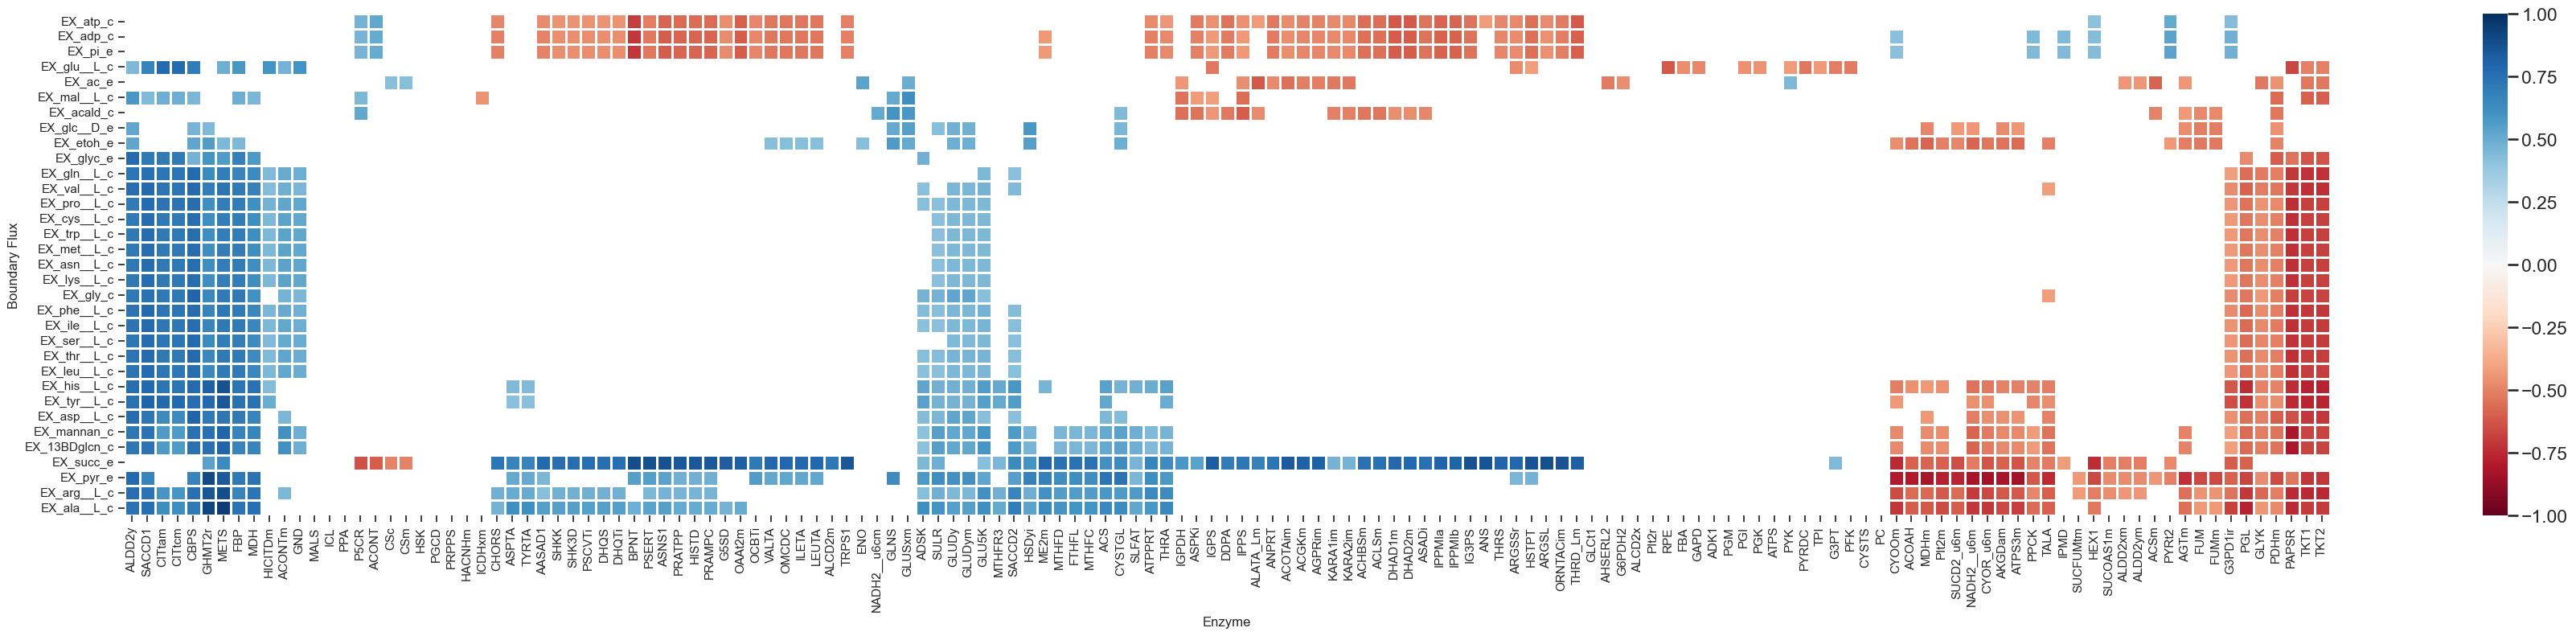

In [304]:
with sns.plotting_context('notebook'):
    fig = plt.figure(figsize=(40,8))
    ax = fig.add_subplot(111, aspect='equal', adjustable='box')

sns.heatmap(sorted_corr_df[p_vals < 0.05].values, vmin=-1, vmax=1,
            cmap='RdBu', cbar=True, rasterized=True, lw=1)

_= ax.set_yticks(np.arange(sorted_corr_df.shape[0]) + 0.5)
_= ax.set_xticks(np.arange(sorted_corr_df.shape[1]) + 0.5)
_ = ax.set_yticklabels(sorted_corr_df.index, rotation=0)
_ = ax.set_xticklabels(sorted_corr_df.columns)

ax.set_xlabel('Enzyme')
ax.set_ylabel('Boundary Flux')

plt.tight_layout()
# plt.savefig('corr_heatmap_large_confident.svg', dpi=75)

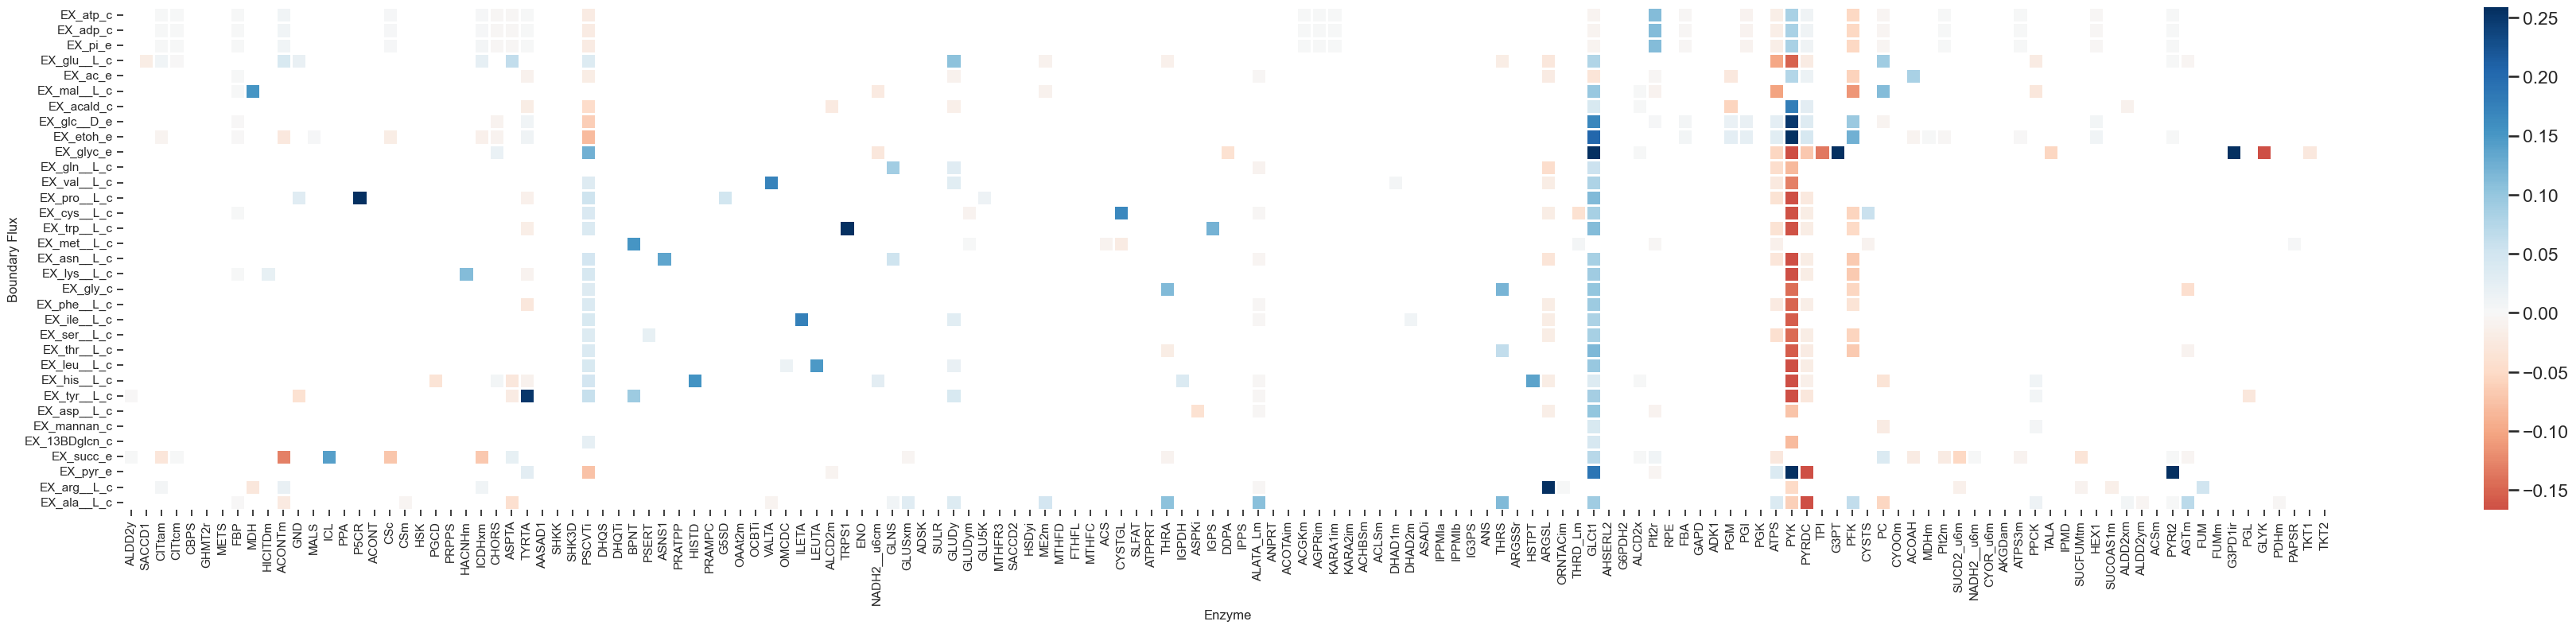

In [305]:
with sns.plotting_context('notebook'):

    fig = plt.figure(figsize=(40,8))
    ax = fig.add_subplot(111, aspect='equal', adjustable='box')

sns.heatmap(fcc_med_measured[fcc_consistent_measured].values,
            center=0, robust=True, cmap='RdBu', cbar=True, rasterized=True, lw=1)

_= ax.set_yticks(np.arange(sorted_corr_df.shape[0]) + 0.5)
_= ax.set_xticks(np.arange(sorted_corr_df.shape[1]) + 0.5)
_ = ax.set_yticklabels(sorted_corr_df.index, rotation=0)
_ = ax.set_xticklabels(sorted_corr_df.columns)

ax.set_xlabel('Enzyme')
ax.set_ylabel('Boundary Flux')

plt.tight_layout()
# plt.savefig('fcc_heatmap_large.svg', dpi=75)

In [10]:
# scratch 
import dill 
import gzip

with gzip.open('data/hackett_advi_expected.pgz') as f:
    expected = dill.load(f)

with gzip.open('data/hackett_advi_actual.pgz') as f:
    actual = dill.load(f)



WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


array([<Axes: xlabel='chi_obs'>, <Axes: xlabel='vn_obs'>], dtype=object)

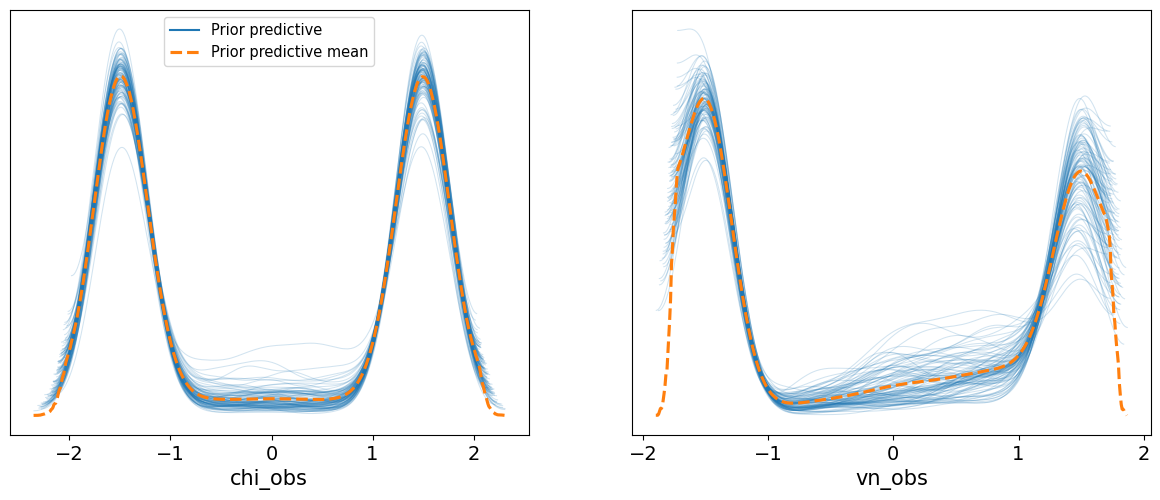

In [23]:
import matplotlib.pyplot as plt
import arviz
import numpy as np
import pymc as pm


# expected_chi_obs = expected['trace_prior']['prior_predictive']['chi_obs']
# actual_chi_obs = actual['trace_prior']['prior_predictive']['chi_obs']

expected_trace_prior = expected['trace_prior']
actual_trace_prior = actual['trace_prior']

arviz.plot_ppc(expected_trace_prior,group ="prior")




array([<Axes: xlabel='chi_obs'>, <Axes: xlabel='vn_obs'>], dtype=object)

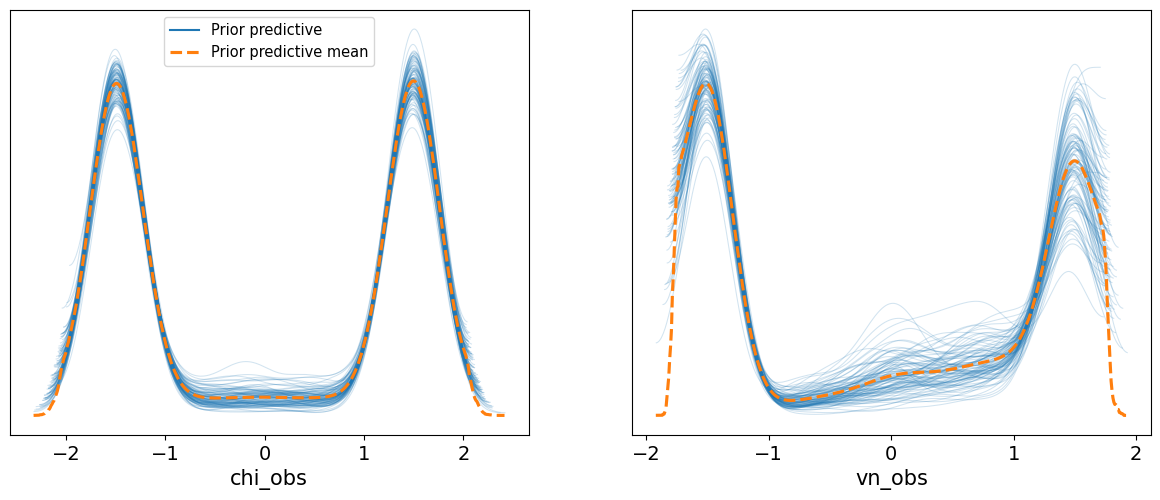

In [24]:
arviz.plot_ppc(actual_trace_prior,group ="prior")

array([[<Axes: title={'center': 'chi_obs'}>,
        <Axes: title={'center': 'chi_obs'}>],
       [<Axes: title={'center': 'vn_obs'}>,
        <Axes: title={'center': 'vn_obs'}>]], dtype=object)

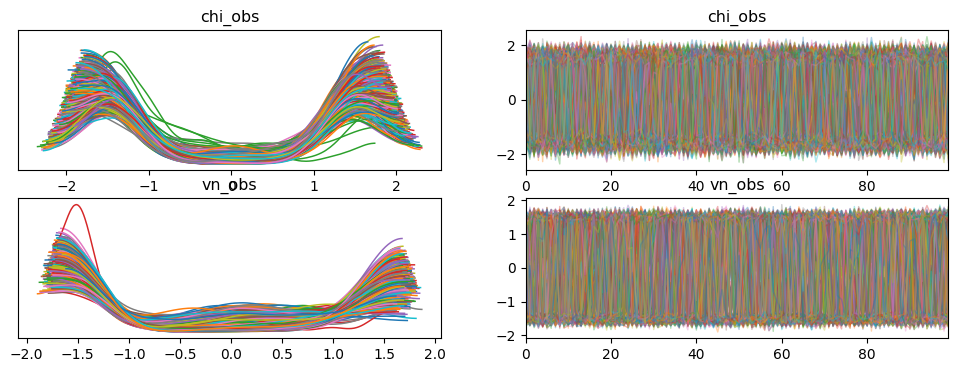

In [28]:
arviz.plot_trace(expected_trace_prior['prior_predictive'])

array([[<Axes: title={'center': 'chi_obs'}>,
        <Axes: title={'center': 'chi_obs'}>],
       [<Axes: title={'center': 'vn_obs'}>,
        <Axes: title={'center': 'vn_obs'}>]], dtype=object)

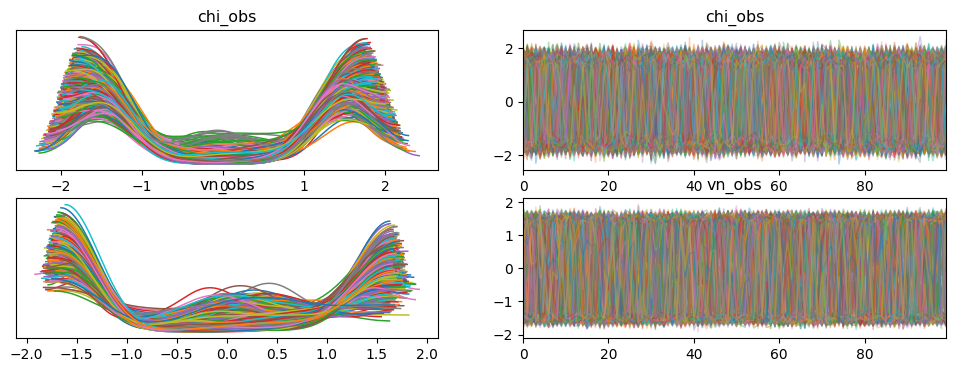

In [29]:
arviz.plot_trace(actual_trace_prior['prior_predictive'])

Text(0.5, 1.0, 'chi obs mean across actual and expected')

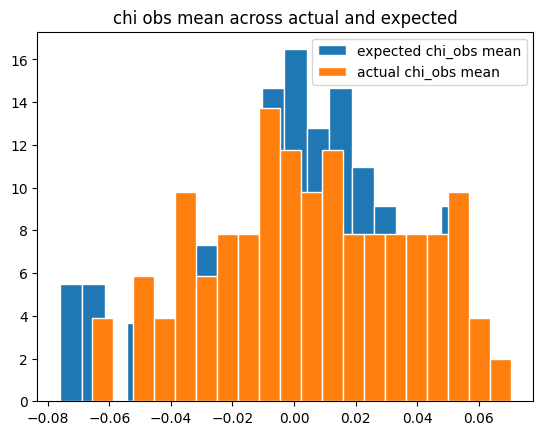

In [65]:


expected_chi_obs = expected['trace_prior']['prior_predictive']['chi_obs']
expected_chi_obs_mean = expected_chi_obs.mean(dim=('chain', 'draw', 'chi_obs_dim_0'))
expected_chi_obs_stdev = expected_chi_obs.std(dim=('chain', 'draw', 'chi_obs_dim_0'))
expected_chi_obs_median = expected_chi_obs.median(dim=('chain', 'draw', 'chi_obs_dim_0'))

actual_chi_obs = actual['trace_prior']['prior_predictive']['chi_obs']
actual_chi_obs_mean = actual_chi_obs.mean(dim=('chain', 'draw', 'chi_obs_dim_0'))
actual_chi_obs_stdev = actual_chi_obs.std(dim=('chain', 'draw', 'chi_obs_dim_0'))
actual_chi_obs_median = actual_chi_obs.median(dim=('chain', 'draw', 'chi_obs_dim_0'))

#plt.bar(np.arange(75), (expected_chi_obs_mean-actual_chi_obs_mean))
#plt.bar(np.arange(75),actual_chi_obs_mean)
#plt.scatter(expected_chi_obs_mean,actual_chi_obs_mean)





plt.hist(expected_chi_obs_mean, bins=20, lw=1,
                        edgecolor='w', density=True, label='expected chi_obs mean')
plt.hist(actual_chi_obs_mean, bins=20, lw=1,
                        edgecolor='w', density=True,label='actual chi_obs mean')
plt.legend()
plt.title('chi obs mean across actual and expected')
# expected_chi_obs_mean = expected_chi_obs_mean.mean(axis=1)
# print(expected_chi_obs_mean.shape)


#actual_chi_obs = actual['trace_prior']['prior_predictive']['chi_obs']

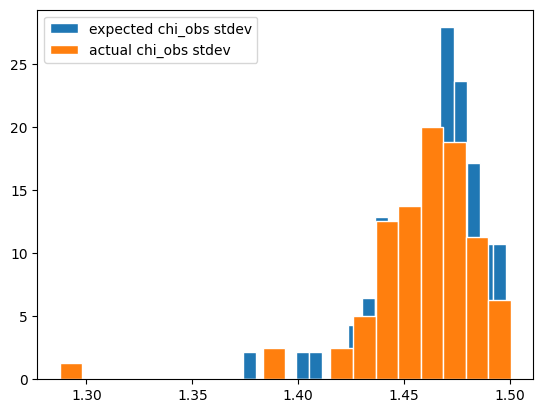

In [56]:
plt.hist(expected_chi_obs_stdev, bins=20, lw=1,
                        edgecolor='w', density=True, label='expected chi_obs stdev')
plt.hist(actual_chi_obs_stdev, bins=20, lw=1,
                        edgecolor='w', density=True,label='actual chi_obs stdev')
plt.legend()


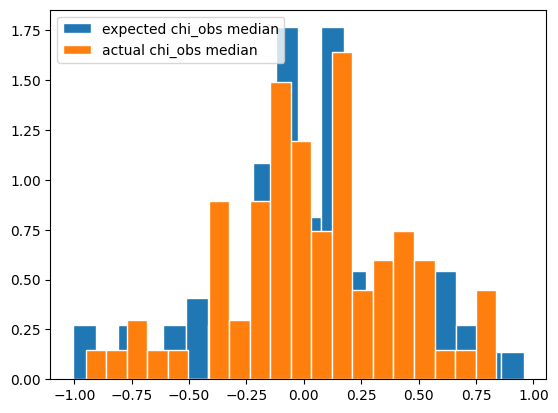

In [59]:
plt.hist(expected_chi_obs_median, bins=20, lw=1,
                        edgecolor='w', density=True, label='expected chi_obs median')
plt.hist(actual_chi_obs_median, bins=20, lw=1,
                        edgecolor='w', density=True,label='actual chi_obs median')
plt.legend()


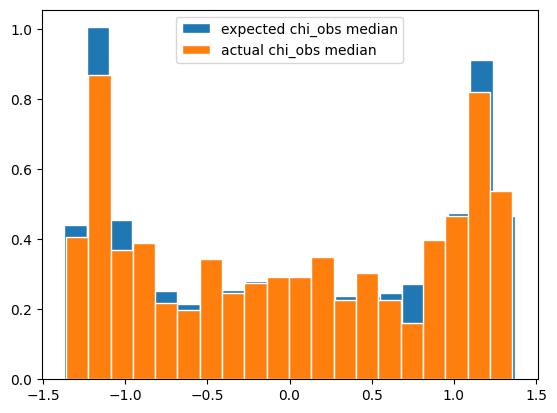

In [64]:
expected_chi_obs = expected['trace_prior']['prior_predictive']['chi_obs']
expected_chi_obs_mean_flat = expected_chi_obs.mean(dim=('chain', 'draw')).to_numpy().flatten()
expected_chi_obs_stdev_flat = expected_chi_obs.std(dim=('chain', 'draw')).to_numpy().flatten()
expected_chi_obs_median_flat = expected_chi_obs.median(dim=('chain', 'draw')).to_numpy().flatten()

actual_chi_obs = actual['trace_prior']['prior_predictive']['chi_obs']
actual_chi_obs_mean_flat = actual_chi_obs.mean(dim=('chain', 'draw')).to_numpy().flatten()
actual_chi_obs_stdev_flat = actual_chi_obs.std(dim=('chain', 'draw')).to_numpy().flatten()
actual_chi_obs_median_flat = actual_chi_obs.median(dim=('chain', 'draw')).to_numpy().flatten()


plt.hist(expected_chi_obs_median_flat, bins=20, lw=1,
                        edgecolor='w', density=True, label='expected chi_obs median')
plt.hist(actual_chi_obs_median_flat, bins=20, lw=1,
                        edgecolor='w', density=True,label='actual chi_obs median')
plt.legend()

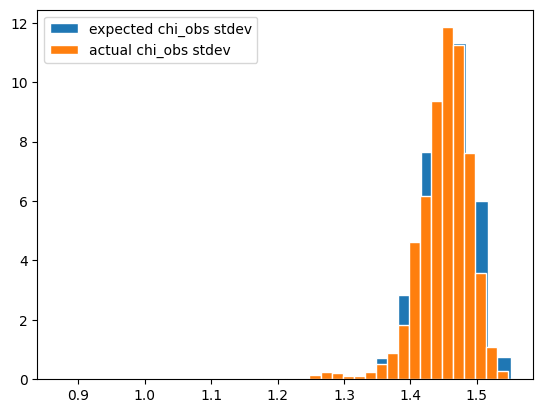

In [67]:
plt.hist(expected_chi_obs_stdev_flat, bins=20, lw=1,
                        edgecolor='w', density=True, label='expected chi_obs stdev')
plt.hist(actual_chi_obs_stdev_flat, bins=20, lw=1,
                        edgecolor='w', density=True,label='actual chi_obs stdev')
plt.legend()

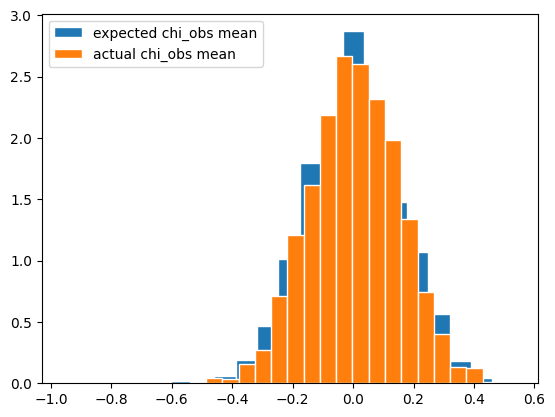

In [68]:
plt.hist(expected_chi_obs_mean_flat, bins=20, lw=1,
                        edgecolor='w', density=True, label='expected chi_obs mean')
plt.hist(actual_chi_obs_mean_flat, bins=20, lw=1,
                        edgecolor='w', density=True,label='actual chi_obs mean')
plt.legend()

In [ ]:
def plot_hpd(ax, expected, actual, error=False, ms=3, alpha=0.5, color='b'):
    # if error:
    #     ax.plot(np.vstack([real.values.flatten(), real.values.flatten()]),
    #             pm.hdi(ppc).to_array().to_numpy().reshape(-1, 2).T, color=color, lw=1, alpha=0.05, zorder=0)
    ax.plot(expected.median(dim=['chain','draw']), actual.median(dim=['chain','draw']), '.', ms=ms, color=color, alpha=alpha, zorder=0)


fig, ax_matrix = plt.subplots(ncols=3, nrows=1, figsize=(6.5, 5),
                              sharex='row', sharey='row')

for ax in ax_matrix[1,:].flatten():
    ax.set_aspect('equal')

_ = ax_matrix[0,0].hist(expected_chi_obs_mean, bins=15, lw=1,
                        edgecolor='w', density=True, facecolor='.4')
_ = ax_matrix[0,1].hist(np.log(np.clip(vn.values.flatten(), 1E-8, 1E8)), bins=15, lw=1,
                        edgecolor='w', density=True, facecolor='.4')
_ = ax_matrix[0,2].hist(np.log(en.values.flatten()), bins=15, lw=1, edgecolor='w',
                        density=True, facecolor='.4')

plot_hpd(ax_matrix[1,0], xn,
         trace.posterior['chi_ss'][:, :, :, x_inds])
plot_hpd(ax_matrix[1,1], np.log(vn),
         np.log(np.clip(trace.posterior['vn_ss'][:, :, :, v_inds], 1E-8, 1E8)))